# 4. Stitch outputs together
- Once you have fitted the weak, medium and dense diads, stitch them all together, and apply the Ne correction model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import DiadFit as pf
pf.__version__

'1.0.11'

In [2]:
# Load in settings, paths, file extensions etc. that you saved in step 1
meta_path, spectra_path, spectra_filetype, prefix, str_prefix, spectra_file_ext, meta_file_ext, TruPower=pf.get_settings()

## Load in specra, and combine

In [3]:
import os
df2=pf.merge_fit_files(path=os.getcwd())
df2.head()

,filename,Splitting,Split_σ,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,...,Diad1_Asym70,Diad1_Yuan2017_sym_factor,Diad1_Remigi2021_BSF,Diad2_Asym50,Diad2_Asym70,Diad2_Yuan2017_sym_factor,Diad2_Remigi2021_BSF,Diad1_PDF_Model,Diad2_PDF_Model,Standard
0,1mol_FIA_r1_nd50,102.708300,0.009218,1285.886821,0.007891,162.752284,1285.886821,230.751833,0.619285,2.243934,...,1.049896,0.051895,0.007610,1.000000,1.010163,0.000000,0.005132,PseudoVoigtModel,PseudoVoigtModel,No
1,1mol_FIA_r2_nd50,102.723235,0.009084,1285.868248,0.007788,164.492226,1285.868248,231.331987,0.616337,2.173665,...,1.010246,0.016840,0.007494,1.045455,1.010417,0.054868,0.004790,PseudoVoigtModel,PseudoVoigtModel,No
2,1mol_FIA_r3_nd50,102.696775,0.009469,1285.875748,0.007904,161.574819,1285.875748,231.920017,0.594648,2.178994,...,1.004158,0.003388,0.007361,1.084746,1.101293,0.104272,0.004987,PseudoVoigtModel,PseudoVoigtModel,No
3,1mol_FIB_r1_nd50,102.708300,0.009218,1285.886821,0.007891,162.752284,1285.886821,230.751833,0.619285,2.243934,...,1.049896,0.051895,0.007610,1.000000,1.010163,0.000000,0.005132,PseudoVoigtModel,PseudoVoigtModel,No
4,1mol_FIB_r2_nd100,102.689723,0.017833,1285.870348,0.016036,104.226567,1285.870348,160.050738,0.626503,2.680833,...,1.092593,0.071117,0.012022,1.018717,1.020921,0.022912,0.006941,PseudoVoigtModel,PseudoVoigtModel,No


## First, get the metadata for this day

In [4]:
# Put the common string you can in all your Ne lines here
diad_meta=pf.get_files(path=spectra_path,
file_ext=meta_file_ext, exclude_str=['Ne', 'FG', 'Cap','window'],
 sort=True)
diad_meta[0]

'1mol_FIA_r1_nd50.txt'

## Now get all the important information out of the metadata files

In [5]:
# This will only work for WITEC - for other vendors, you might have to use the file datastamp. See the HORIBA example
meta=pf.stitch_metadata_in_loop_horiba(path=spectra_path, 
Allfiles=diad_meta)
meta.head()

100%|██████████| 29/29 [00:00<00:00, 30.09it/s]


,filename,spectral_name,date,Month,Day,power (mw),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral_Center
0,1mol_FIA_r1_nd50.txt,13R1W97-102__41,03.09.2025,September,2025-09-03,no data,60.0,4.0,x100,240.0,15:52:54,57174,NaN
1,1mol_FIA_r2_nd50.txt,13R1W97-102__42,03.09.2025,September,2025-09-03,no data,60.0,4.0,x100,240.0,15:58:51,57531,NaN
2,1mol_FIA_r3_nd50.txt,13R1W97-102__43,03.09.2025,September,2025-09-03,no data,60.0,4.0,x100,240.0,16:03:53,57833,NaN
3,1mol_FIB_r1_nd50.txt,13R1W97-102__41,03.09.2025,September,2025-09-03,no data,60.0,4.0,x100,240.0,15:52:54,57174,NaN
4,1mol_FIB_r2_nd100.txt,13R1W97-102__36,03.09.2025,September,2025-09-03,no data,60.0,4.0,x100,240.0,15:23:21,55401,NaN


## Then get a simple file name you can stitch with the spectra

In [6]:
file_m=pf.extracting_filenames_generic(names=meta['filename'],
   file_ext=meta_file_ext)
# Checks they are all unique
file_m[0]

good job, no duplicate file names


'1mol_FIA_r1_nd50'

## Now get filename from spectra into same form as metadata

In [7]:
# Remove these to get the pure file name
file_s=pf.extracting_filenames_generic(
    names=df2['filename'].reset_index(drop=True),
   file_ext=spectra_file_ext)

# Remove the cosmic rays, as doesnt have it in the metatdata
file_s = np.char.replace(file_s.astype(str), "_CRR_DiadFit", "")
print(file_s[0])

good job, no duplicate file names
1mol_FIA_r1_nd50


In [8]:
# Combining them together, if the form above matches, e.g. checking one doesnt have a suffix and the other one does

meta['filename']=file_m
df2['filename']=file_s
df_combo=pd.merge(df2, meta, on='filename').reset_index(drop=True)
df_combo.head()

,filename,Splitting,Split_σ,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,...,Month,Day,power (mw),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral_Center
0,1mol_FIA_r1_nd50,102.708300,0.009218,1285.886821,0.007891,162.752284,1285.886821,230.751833,0.619285,2.243934,...,September,2025-09-03,no data,60.0,4.0,x100,240.0,15:52:54,57174,NaN
1,1mol_FIA_r2_nd50,102.723235,0.009084,1285.868248,0.007788,164.492226,1285.868248,231.331987,0.616337,2.173665,...,September,2025-09-03,no data,60.0,4.0,x100,240.0,15:58:51,57531,NaN
2,1mol_FIA_r3_nd50,102.696775,0.009469,1285.875748,0.007904,161.574819,1285.875748,231.920017,0.594648,2.178994,...,September,2025-09-03,no data,60.0,4.0,x100,240.0,16:03:53,57833,NaN
3,1mol_FIB_r1_nd50,102.708300,0.009218,1285.886821,0.007891,162.752284,1285.886821,230.751833,0.619285,2.243934,...,September,2025-09-03,no data,60.0,4.0,x100,240.0,15:52:54,57174,NaN
4,1mol_FIB_r2_nd100,102.689723,0.017833,1285.870348,0.016036,104.226567,1285.870348,160.050738,0.626503,2.680833,...,September,2025-09-03,no data,60.0,4.0,x100,240.0,15:23:21,55401,NaN


## If you have secondary phases, now is the time to merge those in

In [9]:
df_combo_sec_phase=pf.merge_in_carb_SO2(
df_combo=df_combo, file1_name='Carb_Peak_fits.xlsx', file2_name='SO2_Peak_fits.xlsx', 
prefix=prefix, str_prefix=str_prefix, file_ext=spectra_file_ext)
#df_combo_sec_phase.to_excel('FI_fitting_w_sec_phases.xlsx', index=False)

## If you have SO2, now is the time to calculate the molar proportion of SO2

In [10]:
if 'Peak_Area_SO2' in df_combo_sec_phase:
    

        SO2_mol_ratio=pf.calculate_SO2_CO2_ratio(SO2_area=df_combo_sec_phase['Peak_Area_SO2'], 
        diad1_area=df_combo_sec_phase['Diad1_Voigt_Area'], diad2_area=df_combo_sec_phase['Diad2_Voigt_Area'], 
                SO2_cross_sec=5.3, diad1_cross_sec=0.89, diad2_cross_sec=1.4)
        

        df_combo_sec_phase['SO2_mol_ratio']=SO2_mol_ratio

<ErrorbarContainer object of 3 artists>

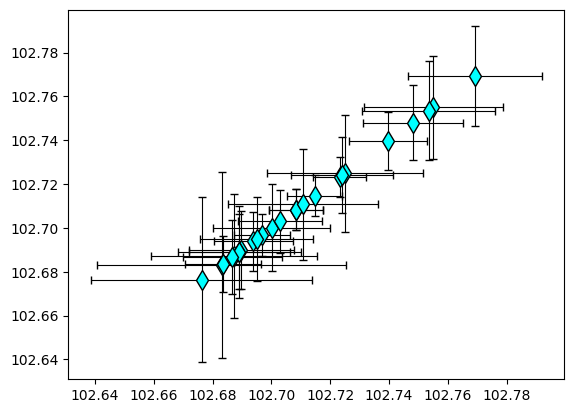

In [11]:

plt.errorbar(df_combo_sec_phase['Splitting'], df_combo_sec_phase['Splitting'], xerr=df_combo_sec_phase['Split_σ'], yerr=df_combo_sec_phase['Split_σ'],
             fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=10, mec='k', capsize=3)

In [12]:
np.std(df_combo_sec_phase['Splitting'])

0.02536961160953229

In [13]:
np.mean(df_combo_sec_phase['Split_σ'])

0.01903899179077044

In [14]:
np.mean(df_combo_sec_phase['Splitting'])

102.71012266661482

## Now we calculate the density using the UC Berkeley Densimeter. 
- If you have your own densimeter, I am happy to add a function for it if you email me (penny_wieser@berkeley.edu)
- This particular function propagates the uncertainty on 1) The neon line correction model 2) the peak fits of the diads themselves 3) The densimeter. 

In [15]:
df=pf.calculate_density_ucb(df_combo=df_combo_sec_phase,
  Ne_pickle_str='Ar_corr_model.pkl',  temp='SupCrit', CI_split=0.67, CI_neon=0.67)
df.head()

9.228880069400702e-06


,filename,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,Preferred D_σ_Ne,...,accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral_Center,time,preferred_values,lower_values,upper_values
0,1mol_FIA_r1_nd50,-0.030533,0.0,0.0,0.0,102.673200,0.009263,0.000942,0.009218,0,...,4.0,x100,240.0,15:52:54,57174,NaN,57174,0.999658,0.999649,0.999667
1,1mol_FIA_r2_nd50,-0.024470,0.0,0.0,0.0,102.688500,0.009129,0.000933,0.009084,0,...,4.0,x100,240.0,15:58:51,57531,NaN,57531,0.999662,0.999653,0.999671
2,1mol_FIA_r3_nd50,-0.034828,0.0,0.0,0.0,102.662358,0.009511,0.000926,0.009469,0,...,4.0,x100,240.0,16:03:53,57833,NaN,57833,0.999665,0.999656,0.999674
3,1mol_FIB_r1_nd50,-0.030533,0.0,0.0,0.0,102.673200,0.009263,0.000942,0.009218,0,...,4.0,x100,240.0,15:52:54,57174,NaN,57174,0.999658,0.999649,0.999667
4,1mol_FIB_r2_nd100,-0.038657,0.0,0.0,0.0,102.652695,0.017854,0.000999,0.017833,0,...,4.0,x100,240.0,15:23:21,55401,NaN,55401,0.999639,0.999630,0.999649


In [17]:
df=pf.calculate_density_ucb(df_combo=df_combo_sec_phase,
  Ne_pickle_str='Ar_corr_model.pkl',  temp='SupCrit', CI_split=0.67, CI_neon=0.67)
df.head()

9.228880069400702e-06


,filename,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,Preferred D_σ_Ne,...,accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral_Center,time,preferred_values,lower_values,upper_values
0,1mol_FIA_r1_nd50,-0.030533,0.0,0.0,0.0,102.673200,0.009263,0.000942,0.009218,0,...,4.0,x100,240.0,15:52:54,57174,NaN,57174,0.999658,0.999649,0.999667
1,1mol_FIA_r2_nd50,-0.024470,0.0,0.0,0.0,102.688500,0.009129,0.000933,0.009084,0,...,4.0,x100,240.0,15:58:51,57531,NaN,57531,0.999662,0.999653,0.999671
2,1mol_FIA_r3_nd50,-0.034828,0.0,0.0,0.0,102.662358,0.009511,0.000926,0.009469,0,...,4.0,x100,240.0,16:03:53,57833,NaN,57833,0.999665,0.999656,0.999674
3,1mol_FIB_r1_nd50,-0.030533,0.0,0.0,0.0,102.673200,0.009263,0.000942,0.009218,0,...,4.0,x100,240.0,15:52:54,57174,NaN,57174,0.999658,0.999649,0.999667
4,1mol_FIB_r2_nd100,-0.038657,0.0,0.0,0.0,102.652695,0.017854,0.000999,0.017833,0,...,4.0,x100,240.0,15:23:21,55401,NaN,55401,0.999639,0.999630,0.999649


### This cell saves the merged together dataframe with the folder name and the date you fitted it

In [18]:

from datetime import date
today = date.today()
today_str = today.strftime("%Y-%m-%d")
sorted_df = df.sort_values('sec since midnight')
date=meta['date'].iloc[0].replace('\n', '')
name='Raman_session_'+date+'_fitted_'+today_str+'.xlsx'
print(name)
sorted_df.to_excel(name)

Raman_session_03.09.2025_fitted_2025-09-08.xlsx


## This helps visualize the errors on each spectra 

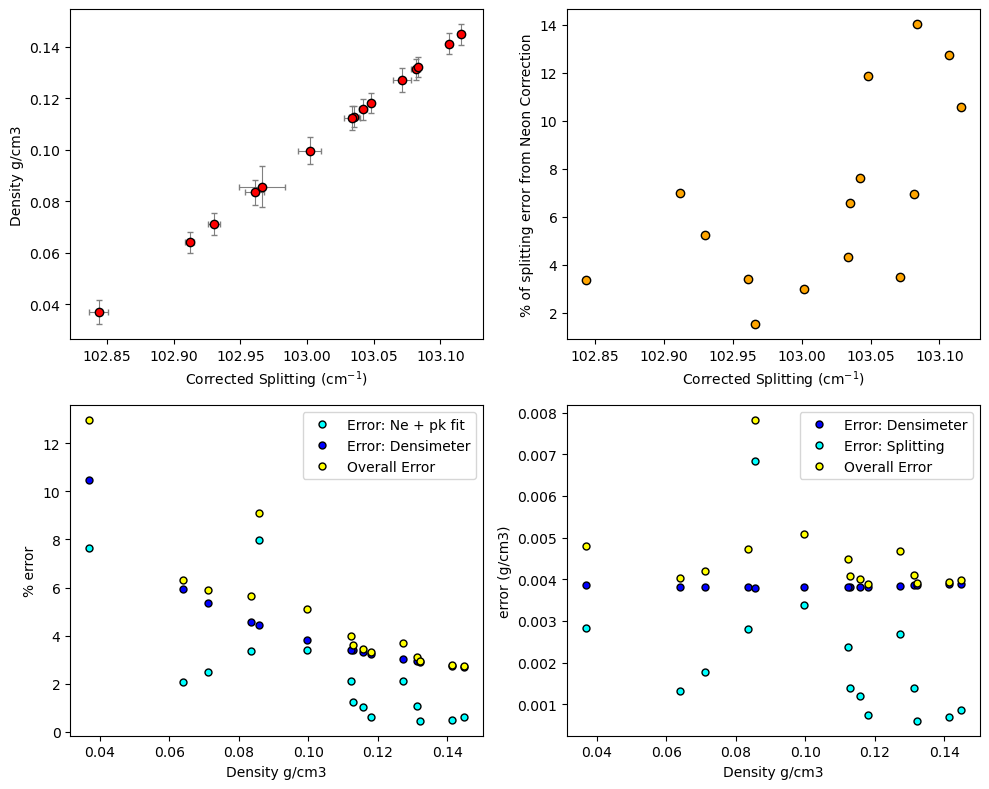

In [ ]:
df=sorted_df
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,8))
df=df.loc[df['Density g/cm3']>0]
ax1.errorbar(df['Corrected_Splitting'], df['Density g/cm3'],
xerr=df['Corrected_Splitting_σ'], yerr=df['σ Density g/cm3'],
fmt='o', ecolor='grey', elinewidth=0.8, mfc='red', ms=6, mec='k', capsize=2)
ax1.set_xlabel('Corrected Splitting (cm$^{-1}$)')
ax1.set_ylabel('Density g/cm3')

ax2.plot(df['Corrected_Splitting'], 
100*df['Corrected_Splitting_σ_Ne']/(df['Corrected_Splitting_σ_Ne']+df['Corrected_Splitting_σ_peak_fit']),
 'ok', mfc='orange')
ax2.set_ylabel('% of splitting error from Neon Correction')
ax2.set_xlabel('Corrected Splitting (cm$^{-1}$)')
ax3.plot(df['Density g/cm3'], 100*df['σ Density g/cm3 (from Ne+peakfit)']/df['Density g/cm3'], 
'ok', mfc='cyan', ms=5, label='Error: Ne + pk fit')


ax3.plot(df['Density g/cm3'], 100*df['σ Density g/cm3 (from densimeter)']/df['Density g/cm3'], 
'ok', mfc='blue', ms=5, label='Error: Densimeter')

ax3.plot(df['Density g/cm3'], 100*df['σ Density g/cm3']/df['Density g/cm3'], 
'ok', mfc='yellow', ms=5, label='Overall Error')
ax3.set_ylabel('% error')
ax3.set_xlabel('Density g/cm3')
ax3.legend()

ax4.plot(df['Density g/cm3'], df['σ Density g/cm3 (from densimeter)'], 
'ok', mfc='blue', ms=5, label='Error: Densimeter')
ax4.plot(df['Density g/cm3'], df['σ Density g/cm3 (from Ne+peakfit)'], 
'ok', mfc='cyan', ms=5, label='Error: Splitting')
ax4.plot(df['Density g/cm3'], df['σ Density g/cm3'], 
'ok', mfc='yellow', ms=5, label='Overall Error')
ax4.set_ylabel('error (g/cm3)')
ax4.set_xlabel('Density g/cm3')
ax4.legend()

fig.tight_layout()

## If you were analysing fluid inclusions, lets calculate their pressures
- This bit isn't valid for melt inclusion vapour bubbles. 

Text(0, 0.5, '# of FI')

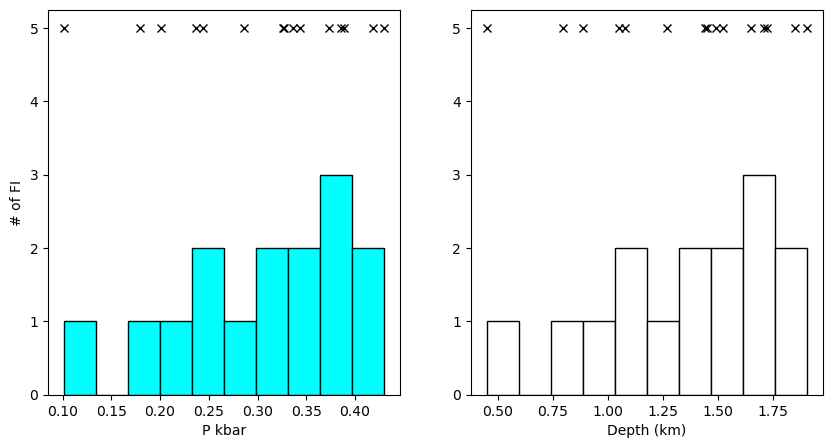

In [ ]:
# Calculate pressure with a temperature estimate
Temp_C=1150
Pressure_SW96=pf.calculate_P_for_rho_T(T_K=Temp_C+273.15,
                CO2_dens_gcm3=df['Density g/cm3'],
                 EOS='SW96')
# Calculate depth from a crustal density assumption
Depth=pf.convert_pressure_to_depth(P_kbar=Pressure_SW96['P_kbar'], 
                crust_dens_kgm3=2300)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(Pressure_SW96['P_kbar'], ec='k', fc='cyan', bins=10)
ax1.plot(Pressure_SW96['P_kbar'], Pressure_SW96['P_kbar']*0+5, 'xk')
ax2.plot(Depth, Pressure_SW96['P_kbar']*0+5, 'xk')
ax2.hist(Depth, ec='k', fc='white', bins=10)
ax1.set_xlabel('P kbar')
ax2.set_xlabel('Depth (km)')
ax1.set_ylabel('# of FI')